# Fig 2

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.colors as colors
import matplotlib.cm as cmx

# Fig 2C: example progress curve
___

In [34]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [35]:
def _forward(x):
    return np.log2(x)


def _inverse(x):
    return 2**x

In [36]:
progress_curve_df = pd.read_csv("/Volumes/DuncanSSD/20240610/data_analysis/20240617_bsadk_progress_curves.csv")

In [37]:
progress_curve_df.head()

,15.625_time,15.625_conc,31.25_time,31.25_conc,62.5_time,62.5_conc,125.0_time,125.0_conc,250.0_time,250.0_conc,500.0_time,500.0_conc,1000.0_time,1000.0_conc,2000.0_time,2000.0_conc,4000.0_time,4000.0_conc
0,0.0,8.727037,0.0,12.664792,0.0,13.753285,0.0,15.874008,0.0,18.600104,0.0,22.823972,0.0,28.600475,0.0,43.314705,0.0,70.885382
1,32.0,9.884077,31.0,16.542211,31.0,26.188165,32.0,48.065910,32.0,75.899952,31.0,105.511126,32.0,133.085877,32.0,160.609294,31.0,195.774297
2,63.0,10.956147,63.0,20.713528,62.0,40.678931,64.0,76.730493,64.0,130.422307,62.0,188.071280,63.0,241.348098,63.0,292.862684,63.0,350.237284
3,94.0,12.223763,94.0,25.886664,94.0,50.319106,95.0,98.127248,95.0,167.922799,94.0,253.570766,95.0,335.484613,95.0,412.260237,94.0,497.559017
4,126.0,12.884060,126.0,27.219788,125.0,55.975909,126.0,111.743376,126.0,196.119225,126.0,301.284632,126.0,410.948219,126.0,516.057121,125.0,632.439119


/var/folders/xh/t0b9z1yd61b4nh7hrj1zy0440000gn/T/ipykernel_67567/2399964800.py:2: RuntimeWarning: divide by zero encountered in log2
  return np.log2(x)


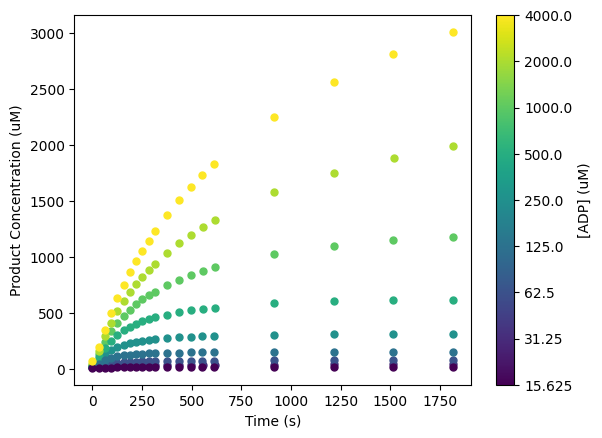

In [43]:
fig, ax = plt.subplots()

conc_strings = list(set([i.split("_")[0] for i in progress_curve_df.columns.tolist()]))
concs = [float(i) for i in conc_strings]

# make a plasma colormap

cmap = plt.cm.viridis
#cmap = truncate_colormap(cmap, .25, .9)
norm = colors.FuncNorm((_forward, _inverse),vmin=min(concs), vmax=max(concs),)
m = cmx.ScalarMappable(norm=norm, cmap=cmap)


for conc, conc_string in zip(concs, conc_strings):

    plt.scatter(progress_curve_df[f"{conc_string}_time"], progress_curve_df[f"{conc_string}_conc"], color=m.to_rgba(conc), s=25)
    # add a line with slope equal to the initial rate
    #plt.plot(initial_rates_df["time_s"], rate * initial_rates_df["time_s"], color=m.to_rgba(conc), linestyle="--", linewidth=2, alpha=0.3)
    # plt.scatter([int(i) for i in row["time_s"].strip("[]").split(",")], 
    #             [float(i) for i in row["chamber_product_concs"].strip("[]").split(",")],
    #             color=m.to_rgba(row["substrate_conc"]), s=25)

plt.xlabel("Time (s)")
plt.ylabel("Product Concentration (uM)")
#plt.xlim(0, 500)
#plt.ylim(0,1500)
# add colorbar
cbar = plt.colorbar(m, ax=ax)
cbar.set_label("[ADP] (uM)")
# set color bar ticks to be substrate concentrations
cbar.set_ticks(concs)
cbar.set_ticklabels(concs)

plt.rcParams['pdf.fonttype'] = 42
plt.savefig("../data/fig_pdfs/b_subt_initial_rates.pdf")

# Fig 2D: example MM
___

In [39]:
example_df = pd.read_csv("/Volumes/DuncanSSD/20240610/data_analysis/20240617_example_mm_params.csv")
example_df.sort_values(by="kcat_mean_normed", ascending=False, inplace=True)

In [40]:
example_df.head()

,id,sample_name,assay_type,replicates,kcat_mean_filtered,kcat_stdev_filtered,Km_mean_filtered,Km_stdev_filtered,kcat_mean_normed,kcat_stdev_normed
3,bsADK,bsADK,mm_filtered,8,2524.812850,391.660956,614.392283,108.897855,269.684781,41.834784
1,ecADK,ecADK,mm_filtered,7,1814.127860,351.095899,538.464375,91.571976,193.773838,37.501877
0,gsADK,gsADK,mm_filtered,6,779.822196,46.936907,273.821872,48.610989,83.295749,5.013508
2,jmADK,jmADK,mm_filtered,5,243.131096,14.703853,176.528422,33.928269,25.969749,1.570574


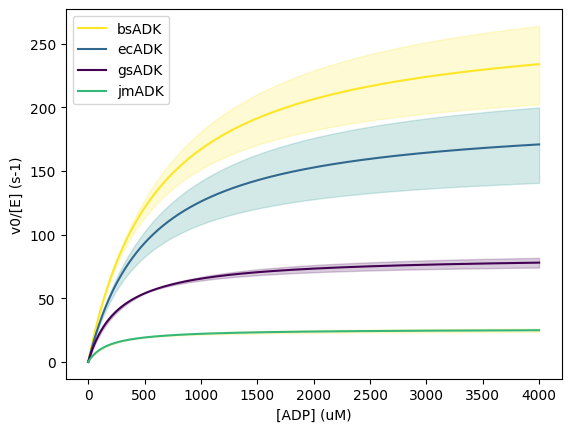

In [42]:
mm_model = lambda x, kcat, Km: kcat * x / (Km + x)
cmap = plt.cm.viridis

x = np.linspace(0, 4000, 1000)
for i, row in example_df.iterrows():
    plt.plot(x, mm_model(x, row["kcat_mean_normed"], row["Km_mean_filtered"]), label=row["id"],c = cmap(i/3))    
    # add shaded confidence interval
    plt.fill_between(x, mm_model(x, row["kcat_mean_normed"] - row["kcat_stdev_normed"], row["Km_mean_filtered"] - row["Km_stdev_filtered"]),
     mm_model(x, row["kcat_mean_normed"] + row["kcat_stdev_normed"], row["Km_mean_filtered"] + row["Km_stdev_filtered"]), alpha=0.2, color=cmap(i/2))

plt.xlabel("[ADP] (uM)")
plt.ylabel("v0/[E] (s-1)")
plt.legend() 
plt.rcParams['pdf.fonttype'] = 42
plt.savefig("../data/fig_pdfs/example_mm_curve.pdf")

In [44]:
published_kcats = {
    'bacillus_subtilis':284.9242411,
    'jeotgalibacillus_marinus':29.91500638,
    'geobacillus_stearothermophilus':112,
    'escherichia_coli ':172,
}

In [45]:
relative_published_kcats = {k: v/published_kcats["bacillus_subtilis"] for k,v in published_kcats.items()}

In [47]:
on_chip_kcats = {
    'bacillus_subtilis':2524.812850,
    'jeotgalibacillus_marinus':243.131096	,
    'geobacillus_stearothermophilus':779.822196,
    'escherichia_coli ':1814.127860,
}

In [48]:
relative_on_chip_kcats = {k: v/on_chip_kcats["bacillus_subtilis"] for k,v in on_chip_kcats.items()}

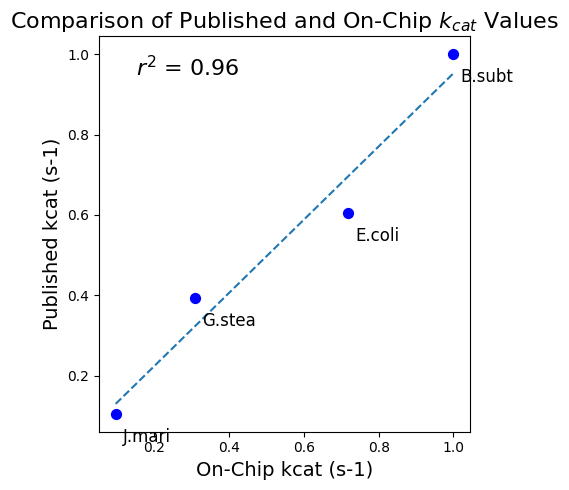

In [50]:
# plot scatter plot of kcat_mean vs publisehd kcat
plt.figure(figsize=(5, 5))

fixed_labels = [i.split("_")[0][0].capitalize() + "." + i.split("_")[1][:4] for i in published_kcats.keys()]

# modify species names
published_kcats_formatted = {k:v for k,v in zip(fixed_labels, published_kcats.values())}


plt.scatter(relative_on_chip_kcats.values(), relative_published_kcats.values(), s=50, c='blue')
plt.xlabel("On-Chip kcat (s-1)", fontsize=14)
plt.ylabel("Published kcat (s-1)", fontsize=14)
plt.title("Comparison of Published and On-Chip $k_{cat}$ Values", fontsize=16)
plt.grid(True)

# add line of best fit as dashed line and r2 value
x = list(relative_on_chip_kcats.values())
y = list(relative_published_kcats.values())

x_lin = np.linspace(min(x), max(x), 100)
m, b = np.polyfit(x, y, 1)
plt.plot(x_lin, m*x_lin + b, '--')

# compute r2
correlation_matrix = np.corrcoef(x, y)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
plt.text(0.1, 0.9, f"$r^2$ = {r_squared:.2f}", transform=plt.gca().transAxes, fontsize=16)

# add text labels
for i, txt in enumerate(published_kcats_formatted.keys()):
    plt.annotate(txt, (x[i], y[i]), xytext=(5, -10), textcoords='offset points', fontsize=12, ha="left" if txt != "B. Subtilis" else "right", va='top')

plt.grid(False)
plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42
plt.savefig("../data/fig_pdfs/relative_published_kcat_comparison.pdf")